In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurements = Base.classes.measurement

In [9]:
stations = Base.classes.station

In [10]:
insp = inspect(engine)

# Look at the columns in the station table

stations_table = insp.get_columns('station')

for c in stations_table :
    print(c['name'], c['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Look at the columns in the measurements table
measurements_table = insp.get_columns('measurement')

for c in measurements_table :
    print(c['name'], c['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [13]:
# Find the most recent date in the data set.  
# Since it creates an ordered list of tuples pick the last by using index -1 then pick the first element of that with [0].
most_recent_date = session.query(measurements.date).order_by('date')[-1][0]
most_recent_date

'2017-08-23'

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. Thanks to tip from slack.
# Starting from the most recent data point in the database. 
from dateutil.relativedelta import relativedelta

# Calculate the date one year from the last date in data set. 
query_date = dt.date.fromisoformat(most_recent_date)-relativedelta(years=1)

In [15]:
# Perform a query to retrieve the data and precipitation scores
annual_precip = session.query(measurements.prcp,measurements.date).filter(measurements.date >= query_date.isoformat() )

In [16]:
# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.read_sql(annual_precip.statement, engine)

In [17]:
df.set_index('date')

,prcp
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2017-08-19,0.09
2017-08-20,NaN
2017-08-21,0.56


In [18]:
# Sort the dataframe by date
df = df.sort_values(by='date')
df

,prcp,date
0,0.00,2016-08-23
1009,NaN,2016-08-23
1529,1.79,2016-08-23
704,0.05,2016-08-23
361,0.15,2016-08-23
...,...,...
1527,0.00,2017-08-22
1008,0.00,2017-08-23
360,0.00,2017-08-23
1528,0.08,2017-08-23


In [19]:
# remove entries without data
clean_df = df.dropna(how="any")

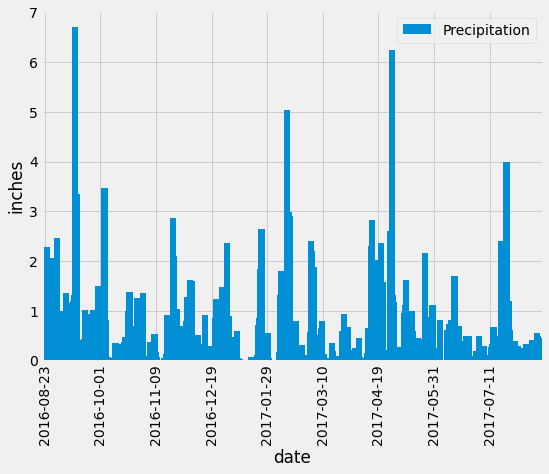

<Figure size 432x288 with 0 Axes>

In [35]:
# Use Pandas Plotting with Matplotlib to plot the data
figure1 = clean_df.plot(x='date', y='prcp', kind='bar',\
                           figsize=(8,6), xlabel="date", ylabel="inches", width=25)

# Set the tick marks for 9 roughly evenly distributed date values
figure1.set_xticks(np.arange(0, len(clean_df), 227))

plt.legend(['Precipitation'], loc="best")
plt.show()
plt.tight_layout()

In [21]:
# Summary Statistics of precipitation data
clean_df['prcp'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: prcp, dtype: float64

# Exploratory Station Analysis

In [22]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(measurements.station).distinct().count()
station_count

9

In [23]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_activity = (session.query(measurements.station, func.count(measurements.date)).\
                    group_by(measurements.station).order_by(func.count(measurements.date).desc() )).all()

In [24]:
station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [25]:
# So the most active station is...
station_activity[0][0]

'USC00519281'

In [26]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_agg = session.query(func.min(measurements.tobs), \
                                       func.max(measurements.tobs), \
                                       func.avg(measurements.tobs) ).\
                                        filter(measurements.station == station_activity[0][0])

In [27]:
most_active_station_agg.all()

[(54.0, 85.0, 71.66378066378067)]

In [28]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
annual_tobs = session.query(measurements.tobs ,measurements.date).filter(measurements.date >= query_date.isoformat() ).\
                            filter(measurements.station == station_activity[0][0])

In [29]:
tobs_df = pd.read_sql(annual_tobs.statement, engine)

In [30]:
# again remove any nans
tobs_df = tobs_df.dropna(how="any")
tobs_df

,tobs,date
0,77.0,2016-08-23
1,77.0,2016-08-24
2,80.0,2016-08-25
3,80.0,2016-08-26
4,75.0,2016-08-27
...,...,...
347,77.0,2017-08-14
348,77.0,2017-08-15
349,76.0,2017-08-16
350,76.0,2017-08-17


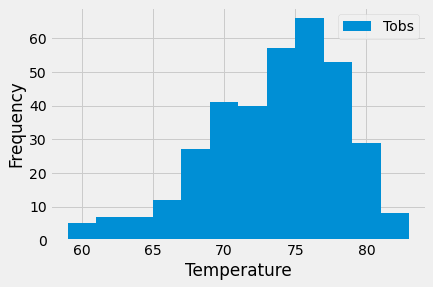

In [31]:
plt.hist(tobs_df['tobs'], bins=12)
plt.legend(['Tobs'])
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close session

In [32]:
# Close Session
session.close()